In [1]:
import twitter
import sys
import time
from urllib2 import URLError
from httplib import BadStatusLine
import json

def oauth_login():
    CONSUMER_KEY = 'UvvZCCaLGcixv9ZCWWDigKarP'
    CONSUMER_SECRET = 'vSRAUDT88kNeVOt2O1x1yi0jHeaR0foZkba4lnjoL6NbHUn0Tt'
    OAUTH_TOKEN = '758714077401284608-Mf0OrF8FG11Ajdqh0tGgN3cIsv70m8n'
    OAUTH_TOKEN_SECRET = 'IjVcfHVqvtB1hhXJuVx3ilDLyCP753gKB7x8a9NktbyeB'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

twitter_api = oauth_login()

In [2]:
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print >> sys.stderr, 'Too many retries. Quitting.'
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print >> sys.stderr, 'Encountered 401 Error (Not Authorized)'
            return None
        elif e.e.code == 404:
            print >> sys.stderr, 'Encountered 404 Error (Not Found)'
            return None
        elif e.e.code == 429: 
            print >> sys.stderr, 'Encountered 429 Error (Rate Limit Exceeded)'
            if sleep_when_rate_limited:
                print >> sys.stderr, "Retrying in 15 minutes...ZzZ..."
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print >> sys.stderr, '...ZzZ...Awake now and trying again.'
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print >> sys.stderr, 'Encountered %i Error. Retrying in %i seconds' % \
                (e.e.code, wait_period)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError, e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError, e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "URLError encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
        except BadStatusLine, e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise

In [3]:
# Modified from book to only get friends

from functools import partial
from sys import maxint

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # See https://dev.twitter.com/docs/api/1.1/get/friends/ids and
    # https://dev.twitter.com/docs/api/1.1/get/followers/ids for details
    # on API parameters
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)

    friends_ids = []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
            print >> sys.stderr, 'Fetched {0} total {1} ids for {2}'.format(len(ids), 
                                                    label, (user_id or screen_name))
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit]

# Sample usage
friends_ids = get_friends_followers_ids(twitter_api, screen_name="wmata", friends_limit=500)
print friends_ids

[69011444, 33547767, 47276713, 78445977, 498852873, 9864112, 15391102, 1267512642, 112476986, 227392869, 245571881, 976542720, 161023696, 124291988, 1602587834, 1522464770, 1522459368, 49660945, 107570696, 14848798, 14345759, 26636274, 285198536, 18768730, 538279790, 14773982, 50420143, 773859192, 24467012, 16129880, 55662510, 15018428, 105537431, 18907371, 39419180, 25208645, 220468862, 17093617, 17045060, 316933625, 117119513, 30844770, 36427475, 20438137, 44711806, 43935910, 13918492, 24714237, 26658777, 131189858, 21978987, 259492037, 11680962, 177445910, 19724699, 250462082, 15005269, 47961897, 2521881, 45707462, 18025557, 24554901, 34349891, 221493459, 18722097, 21789369]


Fetched 66 total friends ids for wmata


In [4]:
# Check to make sure all 66 friends are accounted for
print len(friends_ids)

66


In [5]:
friends_ids

[69011444,
 33547767,
 47276713,
 78445977,
 498852873,
 9864112,
 15391102,
 1267512642,
 112476986,
 227392869,
 245571881,
 976542720,
 161023696,
 124291988,
 1602587834,
 1522464770,
 1522459368,
 49660945,
 107570696,
 14848798,
 14345759,
 26636274,
 285198536,
 18768730,
 538279790,
 14773982,
 50420143,
 773859192,
 24467012,
 16129880,
 55662510,
 15018428,
 105537431,
 18907371,
 39419180,
 25208645,
 220468862,
 17093617,
 17045060,
 316933625,
 117119513,
 30844770,
 36427475,
 20438137,
 44711806,
 43935910,
 13918492,
 24714237,
 26658777,
 131189858,
 21978987,
 259492037,
 11680962,
 177445910,
 19724699,
 250462082,
 15005269,
 47961897,
 2521881,
 45707462,
 18025557,
 24554901,
 34349891,
 221493459,
 18722097,
 21789369]

In [6]:
friends_dict = {}

In [7]:
for friend in friends_ids:
    friends_dict[friend] = get_friends_followers_ids(twitter_api,user_id=friend,friends_limit=5000)
    time.sleep(100)

Fetched 1183 total friends ids for 69011444
Fetched 1025 total friends ids for 33547767
Fetched 2092 total friends ids for 47276713
Fetched 237 total friends ids for 78445977
Fetched 85 total friends ids for 498852873
Fetched 1399 total friends ids for 9864112
Fetched 5000 total friends ids for 15391102
Fetched 495 total friends ids for 1267512642
Fetched 2058 total friends ids for 112476986
Fetched 1095 total friends ids for 227392869
Fetched 957 total friends ids for 245571881
Fetched 858 total friends ids for 976542720
Fetched 252 total friends ids for 161023696
Fetched 873 total friends ids for 124291988
Fetched 684 total friends ids for 1602587834
Fetched 92 total friends ids for 1522464770
Fetched 144 total friends ids for 1522459368
Fetched 0 total friends ids for 49660945
Fetched 760 total friends ids for 107570696
Fetched 226 total friends ids for 14848798
Fetched 699 total friends ids for 14345759
Fetched 278 total friends ids for 26636274
Fetched 340 total friends ids for 28

In [49]:
# Pickle the dict so we don't have to do that again
import pickle
f = open("friends_dict.pkl","wb")
pickle.dump(friends_dict,f)
f.close()

In [50]:
# Load backed up data
with open("C:/Users/00811289/Documents/gradschool/pred452/twitter/mining-web-book/ipynb/friends_dict2.pkl", "rb") as f:
     friends_dict = pickle.load(f)

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [53]:
# Create the first layer of the graph
wmata_friends = nx.Graph()
for immediate_friend in friends_ids:
    wmata_friends.add_edge('wmata', immediate_friend)

In [54]:
# Examine the degree of each node
print(nx.degree(wmata_friends))

[(976542720, 1), (1522464770, 1), (21978987, 1), (20438137, 1), (107570696, 1), (498852873, 1), (11680962, 1), (49660945, 1), (124291988, 1), (24554901, 1), (177445910, 1), (105537431, 1), (78445977, 1), (117119513, 1), (13918492, 1), (14848798, 1), (14345759, 1), (19724699, 1), (43935910, 1), (47276713, 1), (39419180, 1), (259492037, 1), (55662510, 1), (50420143, 1), (9864112, 1), (18722097, 1), (1602587834, 1), (21789369, 1), (112476986, 1), (15018428, 1), (250462082, 1), (1267512642, 1), (34349891, 1), (24467012, 1), (25208645, 1), (45707462, 1), (285198536, 1), (47961897, 1), (2521881, 1), (131189858, 1), (161023696, 1), (36427475, 1), (15005269, 1), (316933625, 1), (16129880, 1), (26658777, 1), (18768730, 1), (245571881, 1), (14773982, 1), (30844770, 1), (227392869, 1), (1522459368, 1), (44711806, 1), (18907371, 1), (538279790, 1), (17093617, 1), (26636274, 1), (221493459, 1), (69011444, 1), (220468862, 1), (17045060, 1), (33547767, 1), (773859192, 1), ('wmata', 66), (24714237, 1)

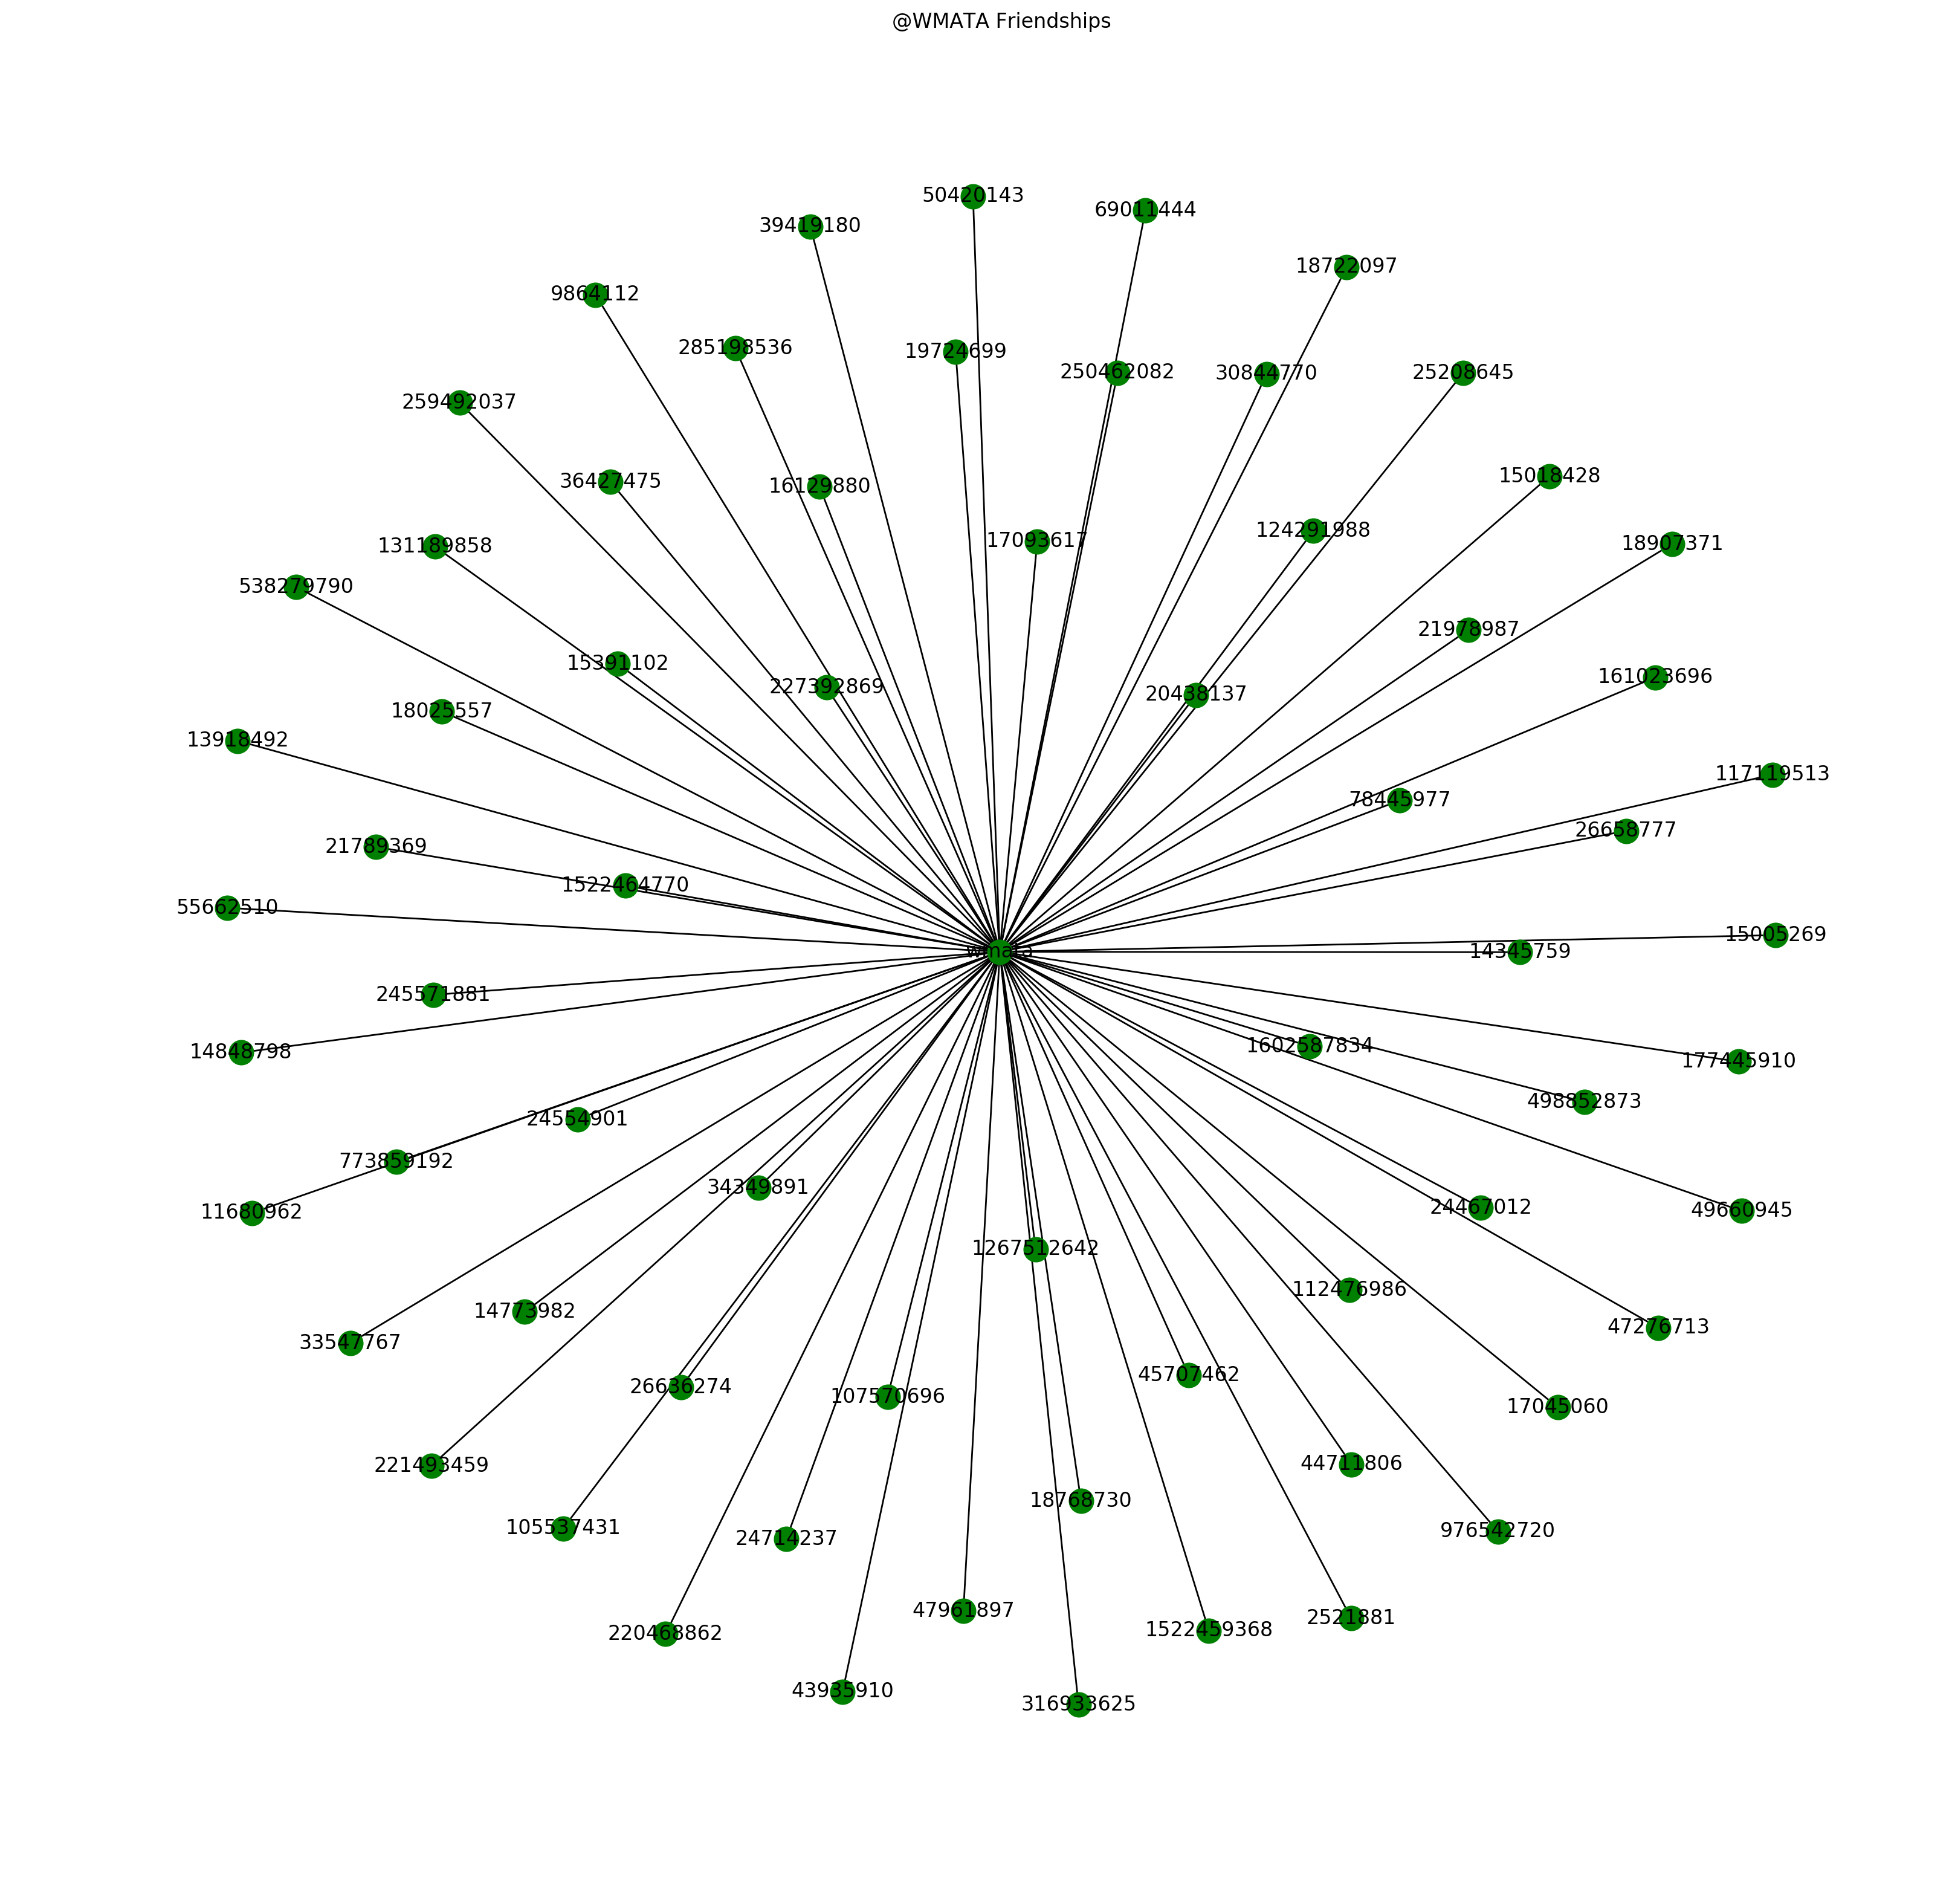

In [62]:
fig = plt.figure(figsize=(20, 20), dpi=200)
nx.draw_networkx(wmata_friends, node_size = 200, node_color = 'green')
plt.title("@WMATA Friendships")
plt.axis('off')
plt.show()

In [63]:
wmata_friends2 = wmata_friends

In [85]:
# Create the second layer of the graph
for k, dk in friends_dict.iteritems():
    for x in dk:
        wmata_friends2.add_edge(k, x)

In [87]:
# https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling
labels = {}    
color_map = []
node_size_map = []
for node in wmata_friends2.nodes():
    if node in friends_ids:
        labels[node] = node
        color_map.append('blue')
        node_size_map.append(200)
    else: 
        color_map.append('green')
        node_size_map.append(20)
        
fig = plt.figure(figsize=(20, 20), dpi=400)
pos = nx.spring_layout(wmata_friends2)
nx.draw_networkx(wmata_friends2, pos=pos, node_size = node_size_map, node_color = color_map, edge_color = 'gray', font_size=8, with_labels=False)
plt.title("@WMATA Friendships")
plt.axis('off')

nx.draw_networkx_labels(wmata_friends2,pos,labels,font_size=8)
plt.savefig('output.png')


In [74]:
friends_dict

{2521881: [858821,
  6145472,
  9441332,
  10081372,
  7914212,
  720863,
  6080762,
  5352542,
  4052051,
  9599582,
  882771,
  1020161,
  12431,
  720893,
  7685382,
  9120732,
  7809082,
  6806472,
  6761162,
  5691492,
  5507542,
  5435842,
  5166511,
  2890111,
  831981,
  56183,
  27603,
  3301,
  822941,
  18713],
 9864112: [3529414818L,
  16438430,
  400344850,
  958638532746235904L,
  57017317,
  572744215,
  61374047,
  15724503,
  912302742,
  22310997,
  62902733,
  17242789,
  38936142,
  60783724,
  235189067,
  935158026985725952L,
  2557350530L,
  491350930,
  166739404,
  26283307,
  564069706,
  134196350,
  455824116,
  840054098598715392L,
  2812768561L,
  23135517,
  17017636,
  152464672,
  742497856133562368L,
  14848798,
  2230566564L,
  15264511,
  226426787,
  1250456282,
  22156181,
  33653195,
  2814822190L,
  2299103580L,
  71521577,
  123971837,
  500704345,
  130149985,
  16118322,
  877167919704289280L,
  119543635,
  315331161,
  57721889,
  372347731,